Из `sdr` приемников мы получаем IQ отсчеты. Рассмотрим, как получить из IQ отсчетов энергетический спектр
и спектрограмму.

In [1]:
import numpy as np
import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

In [2]:
sample_rate = 20e6
center_freq = 5e6
samples = 131072
NFFT = 128

## Попробуем сгенерировать сигнал, выполнить БПФ и получить амплитудный спектр

$$s(t) = e^{j 2 \pi f_s t}$$

In [3]:
time = np.linspace(0, samples/sample_rate, samples)

iq = np.exp(2j*np.pi*center_freq*time)
print(f"Сomplex numbers for iq samples were generated, shape={iq.shape}")

Сomplex numbers for iq samples were generated, shape=(131072,)


#### Расчет спектра:

In [4]:
spectrum = np.fft.fftshift(np.fft.fft(iq))
print(f"Results obtained using FFT, shape={spectrum.shape} ")

Results obtained using FFT, shape=(131072,) 


#### Расчет частот

In [5]:
freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=1/sample_rate))

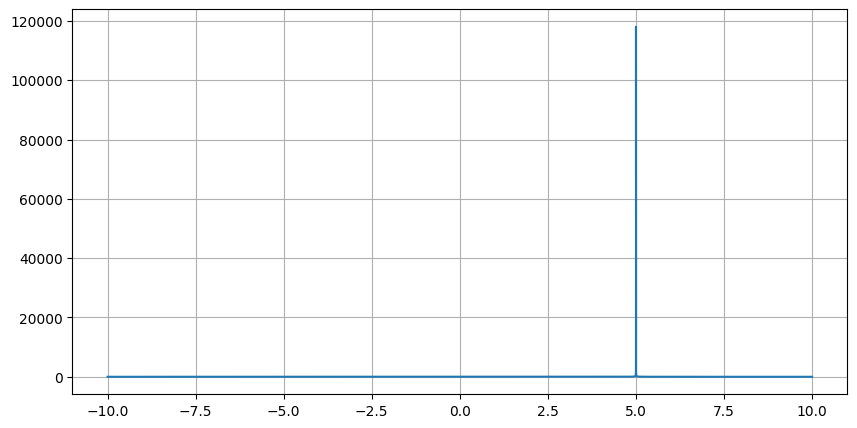

In [6]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(spectrum))  # in MHz
plt.grid()

#### Для реального сигнала спектр будет симметричным

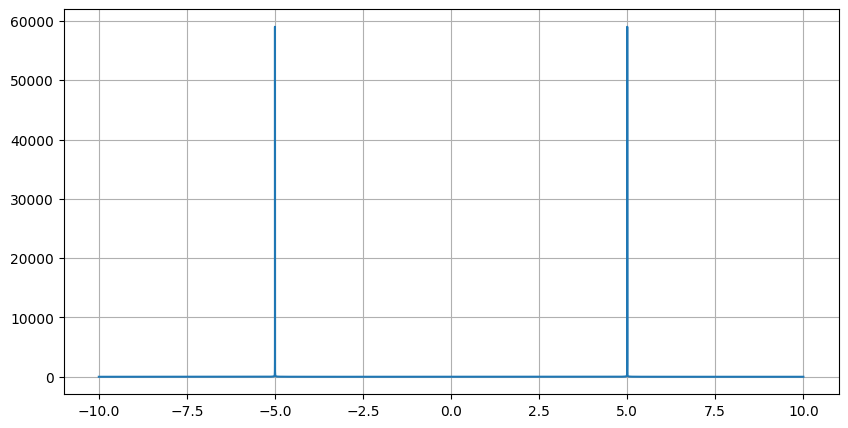

In [7]:
spectrum = np.fft.fftshift(np.fft.fft(iq.real))

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e6, np.abs(spectrum))  # in MHz
plt.grid()

## Нужно улучшить

* теперь получим не амплитудный спектр, а энергетический
* построим спектрограмму

https://github.com/matplotlib/matplotlib/blob/v3.9.0/lib/matplotlib/mlab.py#L213

In [8]:
P, freqs, t = mlab._spectral_helper(x=iq, y=None, NFFT=NFFT, Fs=sample_rate,
                                     detrend_func=None, noverlap=0, mode='psd')
print(f"P.shape={P.shape}, freqs.shape={freqs.shape}, t.shape={t.shape}")

freqs /= 1e6  # in MHz
P = np.abs(P)
# Если нужно перевести в dB
# P = 10. * np.log10(P)

P.shape=(128, 1024), freqs.shape=(128,), t.shape=(1024,)


#### Энергетический спектр и спектрограмма

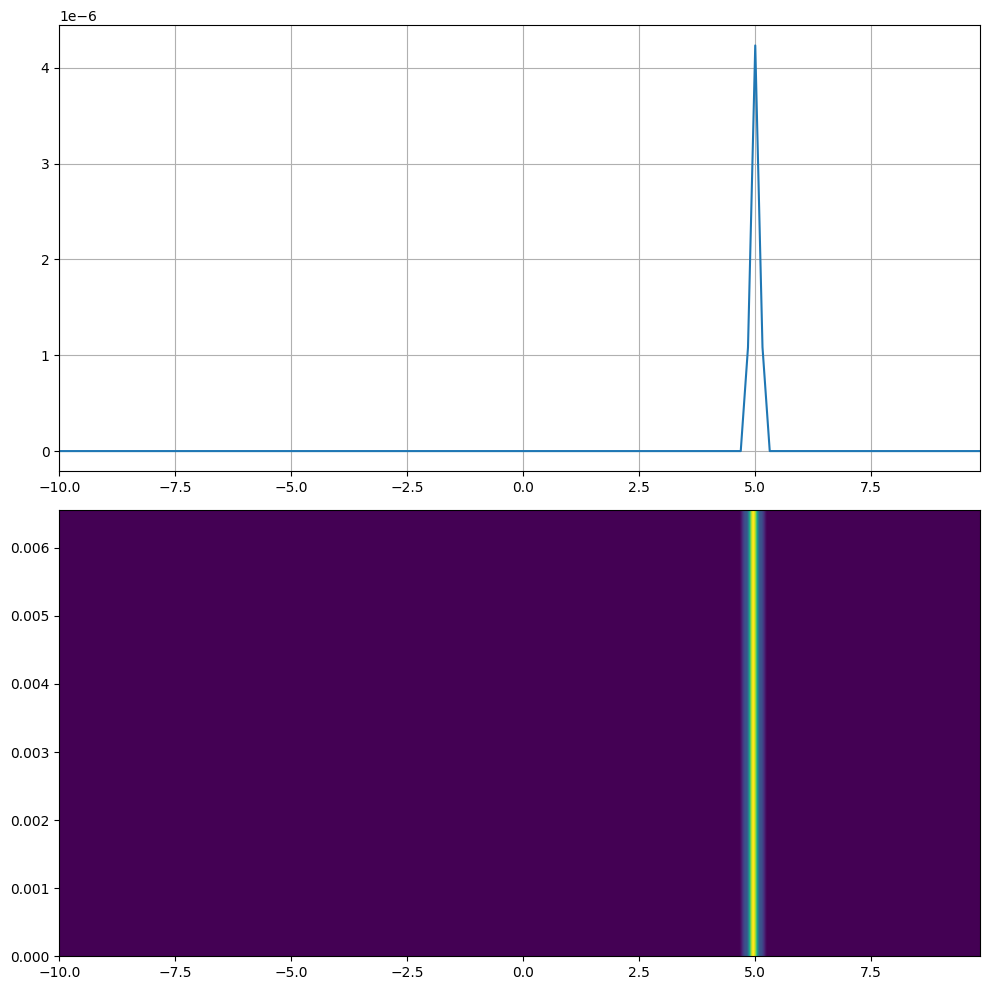

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# Спектр
psd = P.mean(axis=1)
ax1.plot(freqs, psd)  # in MHz
ax1.grid(True)
ax1.set_xlim(freqs[0], freqs[-1])

# Спектрограмма
spectrogram = P.T
pad_xextent = NFFT / sample_rate / 2
xextent = np.min(t) - pad_xextent, np.max(t) + pad_xextent
tmin, tmax = xextent
extent = freqs[0], freqs[-1], tmin, tmax
ax2.imshow(spectrogram, extent=extent, aspect='auto')

plt.tight_layout()
plt.show()

## Прочитает сигнал с hackrf

In [10]:
!hackrf_info

hackrf_info version: unknown
libhackrf version: unknown (0.6)
Found HackRF
Index: 0
Serial number: 0000000000000000600463dc2b1a75c7
Board ID Number: 4 (Unknown Board ID)
Firmware Version: 2023.01.1 (API:1.07)
Part ID Number: 0xa000cb3c 0x00584f59


In [12]:
from hackrf import HackRF

hrf = HackRF()
hrf.sample_rate = sample_rate
hrf.center_freq = center_freq

iq = hrf.read_samples()

LNA gain set to 16 dB.
VGA gain set to 16 dB.


#### Можно записать в файл

(Это не обязательно, можно просто подавать на вход полученные IQ)

In [13]:
np.savez("./app/data/example.npz", iq)

## Теперь прочитаем записанный на hackrf сигнал

In [14]:
signals = np.load("./app/data/example.npz")
print(signals.files)
iq = signals["arr_0"]
print(f"IQ shape={iq.shape}")

['arr_0']
IQ shape=(131072,)


#### Расчет спектра + график

In [15]:
P, freqs, t = mlab._spectral_helper(x=iq, y=None, NFFT=NFFT, Fs=sample_rate,
                                     detrend_func=None, noverlap=0, mode='psd')
print(f"P.shape={P.shape}, freqs.shape={freqs.shape}, t.shape={t.shape}")

freqs = (freqs + center_freq) / 1e6  # in MHz
P = np.abs(P)
# Если нужно перевести в dB
P = 10. * np.log10(P)

P.shape=(128, 1024), freqs.shape=(128,), t.shape=(1024,)


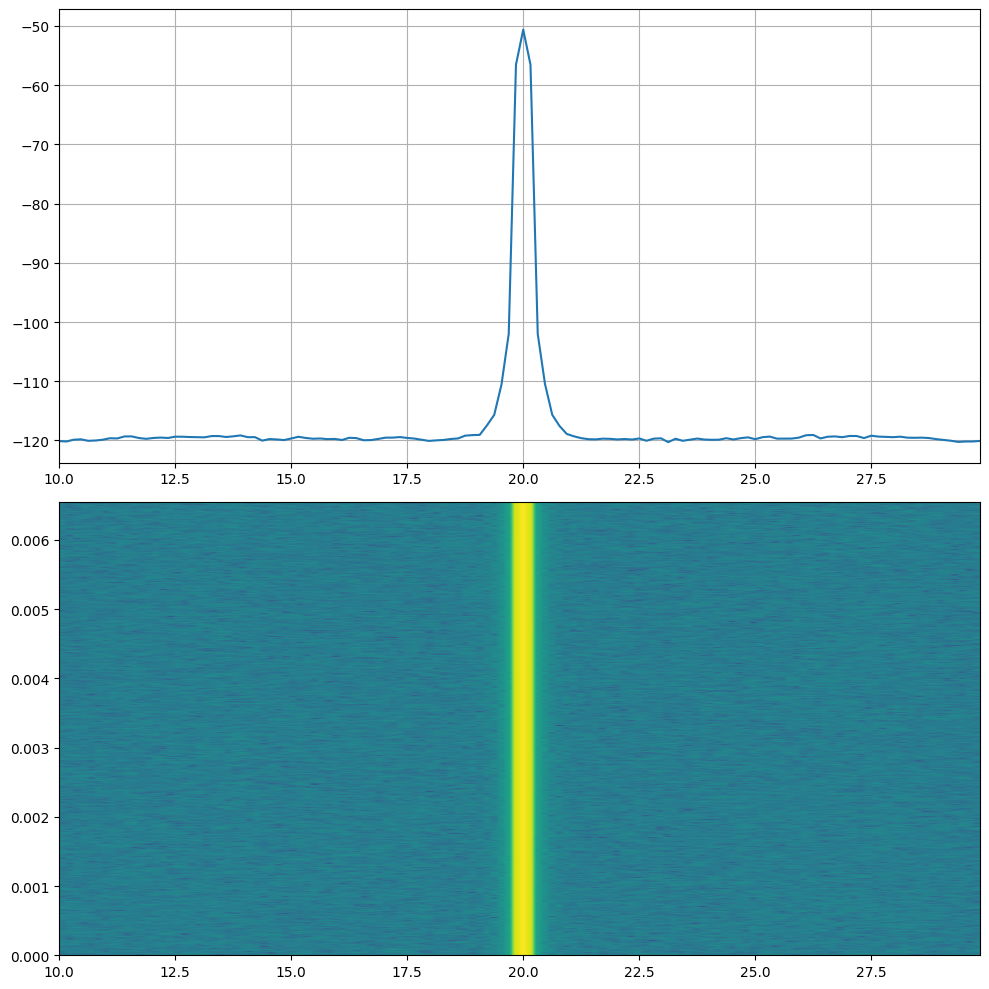

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# Спектр
psd = P.mean(axis=1)
ax1.plot(freqs, psd)  # in MHz
ax1.grid(True)
ax1.set_xlim(freqs[0], freqs[-1])

# Спектрограмма
spectrogram = P.T
pad_xextent = NFFT / sample_rate / 2
xextent = np.min(t) - pad_xextent, np.max(t) + pad_xextent
tmin, tmax = xextent
extent = freqs[0], freqs[-1], tmin, tmax
ax2.imshow(spectrogram, extent=extent, aspect='auto')

plt.tight_layout()
plt.show()

[source](https://hackrf.readthedocs.io/en/latest/faq.html)

Если вы видите большой всплеск на центральной частоте спектра независимо от частоты, на которую вы настроены, вы видите смещение постоянного тока (`DC offset/component/bias`). Это неизменный аспект сигнала в отличие от «переменной» части сигнала, которая меняется со временем. Смещение постоянного тока не уникально для HackRF, это общее для всех систем квадратурной выборки.

#### Компенсируем DC offset с помощью `mlab.detrend_linear`

In [17]:
P, freqs, t = mlab._spectral_helper(x=iq, y=None, NFFT=NFFT, Fs=sample_rate,
                                     detrend_func=mlab.detrend_linear, noverlap=0, mode='psd')
print(f"P.shape={P.shape}, freqs.shape={freqs.shape}, t.shape={t.shape}")

freqs = (freqs + center_freq) / 1e6  # in MHz
P = np.abs(P)
# Если нужно перевести в dB
P = 10. * np.log10(P)
# При применении mlab.detrend_linear, частота посередине спектра была удалена
P[NFFT//2, :] = P[NFFT//2 + 1, :]

P.shape=(128, 1024), freqs.shape=(128,), t.shape=(1024,)


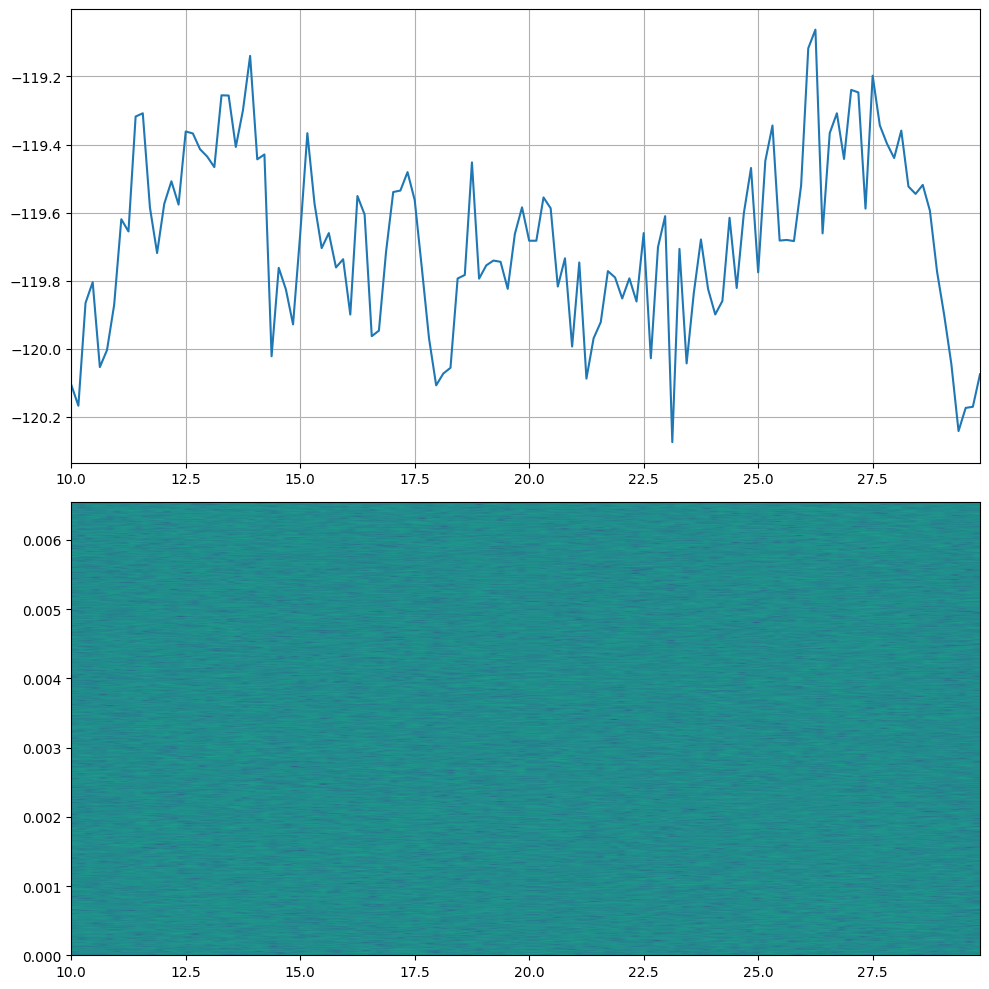

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# Спектр
psd = P.mean(axis=1)
ax1.plot(freqs, psd)  # in MHz
ax1.grid(True)
ax1.set_xlim(freqs[0], freqs[-1])

# Спектрограмма
spectrogram = P.T
pad_xextent = NFFT / sample_rate / 2
xextent = np.min(t) - pad_xextent, np.max(t) + pad_xextent
tmin, tmax = xextent
extent = freqs[0], freqs[-1], tmin, tmax
ax2.imshow(spectrogram, extent=extent, aspect='auto')

plt.tight_layout()
plt.show()

## Чтение записанных ранее файлов

In [21]:
import numpy as np
import matplotlib.pyplot as plt

f = np.load("./app/data/example/0.npz")
iq = f["iq2"]
sample_rate = f["sample_rate"]
center_freq = f["center_freq"]

P, freqs, t = mlab._spectral_helper(x=iq, y=None, NFFT=NFFT, Fs=sample_rate,
                                     detrend_func=mlab.detrend_linear, noverlap=0, mode='psd')
freqs = (freqs + center_freq) / 1e6  # in MHz
P = np.abs(P)
# Если нужно перевести в dB
P = 10. * np.log10(P)
# При применении mlab.detrend_linear, частота посередине спектра была удалена
P[NFFT//2, :] = P[NFFT//2 + 1, :]

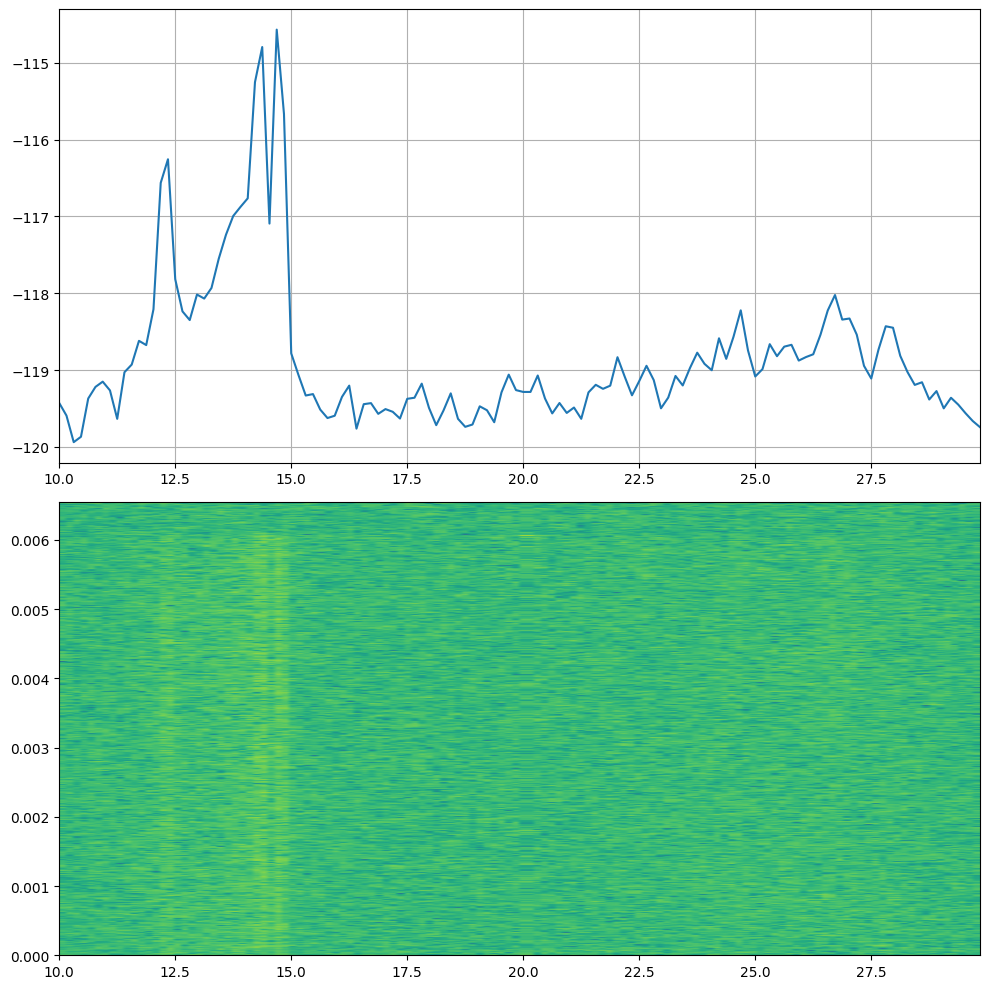

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# Спектр
psd = P.mean(axis=1)
ax1.plot(freqs, psd)  # in MHz
ax1.grid(True)
ax1.set_xlim(freqs[0], freqs[-1])

# Спектрограмма
spectrogram = P.T
pad_xextent = NFFT / sample_rate / 2
xextent = np.min(t) - pad_xextent, np.max(t) + pad_xextent
tmin, tmax = xextent
extent = freqs[0], freqs[-1], tmin, tmax
ax2.imshow(spectrogram, extent=extent, aspect='auto')

plt.tight_layout()
plt.show()

In [20]:
hrf.close()